In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

In [3]:
@tool
def get_weather(location: str):
    """ Call to get the weather """ #Agent가 설명을 보고 참고
    if location in ["서울", "인천"]:
        return "It's 60 degree and foggy"
    else:
        return "It's 90 degree and foggy"
    
@tool
def get_cooliest_cities():
    """Get cooliest cities"""
    return "서울, 고성"

In [4]:
tools = [get_weather,get_cooliest_cities]
tool_node = ToolNode(tools) #Tool node 안에 여러 위에 선언했던 tools가 리스트형태로 들어있음.

In [5]:
from langchain_openai import ChatOpenAI

model_with_tools = ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).bind_tools(tools)

In [6]:
model_with_tools.invoke("서울 날씨는 어때?").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_DXz6H2fUfOHYbcNCHq61pu9i',
  'type': 'tool_call'}]

In [7]:
model_with_tools.invoke("한국에서 가장 추운 도시는?").tool_calls

[{'name': 'get_cooliest_cities',
  'args': {},
  'id': 'call_xRmCg6JGfvo9RboKVhSx8kKy',
  'type': 'tool_call'}]

In [ ]:
# Tool node는 그래프 컨텍스트 안에서만 호출 가능 외부로는 호출 불가함.
#tool_node.invoke({"messages" : [model_with_tools.invoke("서울 날씨는 어때?")]})

ValueError: Missing required config key 'N/A' for 'tools'.

In [ ]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START,StateGraph, MessagesState

def should_continue(state:MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state:MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

# 워크플로우 선언
workflow = StateGraph(MessagesState)

# 노드 정의
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

#add a conditional node - 
workflow.add_conditional_edges(
    "agent", #시작 노드
    should_continue, # 조건 반환
    {
      "tools": "tools", #tool 반환 시 tool
       END : END   #End 반환 시 End
    } 
)

workflow.add_edge("tools", "agent")

app = workflow.compile()

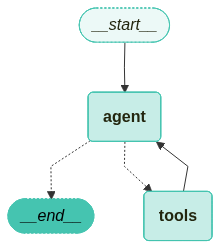

In [20]:
from langchain_teddynote.graphs import visualize_graph
visualize_graph(app)

In [28]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어때?")]}
)
final_state["messages"][-1].content

'서울의 날씨는 60도(약 15도)이며 안개가 낀 상태입니다.'

In [29]:
for chunk in app.stream(
    {"messages": [("human", "가장 추운 도시의 날씨는 어때")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

가장 추운 도시의 날씨는 어때
================================== Ai Message ==================================
Tool Calls:
  get_cooliest_cities (call_ZiMqu75yE3fIP6j3gug5Jar3)
 Call ID: call_ZiMqu75yE3fIP6j3gug5Jar3
  Args:
================================= Tool Message =================================
Name: get_cooliest_cities

서울, 고성
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_AiWZx3QFKNIiIIfdbjCu5KNX)
 Call ID: call_AiWZx3QFKNIiIIfdbjCu5KNX
  Args:
    location: 서울
  get_weather (call_hDgVW4VIDsmUNb5uN3YmlOVt)
 Call ID: call_hDgVW4VIDsmUNb5uN3YmlOVt
  Args:
    location: 고성
================================= Tool Message =================================
Name: get_weather

It's 90 degree and foggy
================================== Ai Message ==================================

가장 추운 도시인 서울의 날씨는 60도(약 15도)로 안개가 끼어 있습니다. 고성의 날씨는 90도(약 32도)로 역시 안개가